# NMR Processing Tutorial TESTING SAVE FUNCTION
In this notebook we are going to take the free-induction decay (FID) from an NMR and graph it as an NMR spectrum.  To do this we are going to first import three modules, numpy which helps us handle some math, matplotlib which is a graphing module and finally nmrglue.  The nmrglue package is an open-source package for analyzing and graphing nmr spectra. It usually doesn't come preinstalled so the first thing we will do is install it using pip.

In addition, you will need to get four files that you will use to create the two NMR spectra. These four files are the D2O\_fid, D2O\_procpar, NoD2O\_fid, and NoD2O\_procpar files, and were collected on an Agilent 400 MHz NMR. These should also already be loaded into the notebook folder.

We can use %pip to in install nmrglue. The syntax to install it is pretty straight forward. In the codeblock below I have written it out for you. It takes a while to run so wait until after the star symbol turns back to the number [1].

In [60]:
%pip install nmrglue


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex


Next, in the codeblock below we have the three modules we are going to be using but we need to import them before we can use them.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import nmrglue as ng

### 1. Plotting the FID
One of the advantages to the nmrglue package is that it lets us import data using the proprietary files created by the NMR system software. For example, we can use the read_fid() function in the nmrglue package to read Agilent NMR files, without having to turn them into an open-source data file first. I'm going to start with the NoD2O\_fid and NoD2O\_procpar files, which contain the necessary data to create one NMR spectrum. The fid file contains the data from the Free Induction Decay (FID) this is actully a 2d array of data so to read it in we need two sets, one called d, and one called data.
The second file the one called NoD2O\_procpar is the parameter file, which contains a lot of details about how the file was collected such as how long it too for the scan. We will call this params (short for parameters).

In [50]:
dic, data = ng.fileio.agilent.read_fid("NoD2O_fid", as_2d=True)
params = ng.fileio.agilent.read_procpar("NoD2O_procpar")


Now that we've read in the fid and parameter file, we can work with it. First, let's have a look at the free induction decay file to see what it looks like.
Below I am plotting the data from the FID file using matplotlib.

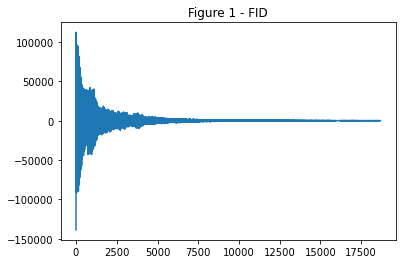

In [51]:
plt.plot(data.real[0])
plt.title("Figure 1 - FID")
plt.show()

Above we have plotted the FID, as you can see its hard to see how we can get much information from it. The biggest problem at this point is that the x-axis is wrong. To keep the FID files small the way the software stores FID data is as a series of values, and so when we graph that data the x-axis is just a number. However, the x-axis should be time, not a point number, so we have to create an array of points with the value of time that each data point was collected. To do this, we  need to know how long the total acquisition time of the FID was and the total number of points. Then we can simply divide the two to find to find the time per point, and then use that to create an array of times. As I mentioned above the the acquisition time is stored in the params file. It is stored as "at" in the "params" array so we can find out how long it took from this below.

In [52]:
acq_time = float(params['at']['values'][0])
time_per_point = acq_time/(data.shape[1])
time=np.arange(0,acq_time,time_per_point)
print("The FID acquisition took " + "{:1.5}".format(acq_time) + " seconds.")

The FID acquisition took 2.6001 seconds.


Now let's look at the FID with the correct x-axis.

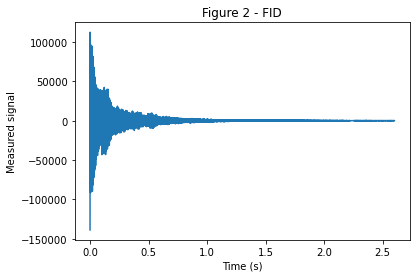

In [53]:
plt.plot(time,data.real[0])
plt.title("Figure 2 - FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

Alright, if you look now our x axis is in time now, but its still hard to get any information out of this by eye. So we are going to have to go a bit deeper. If you look above in the code when we plotted the data you can see we only plotted the 'real' part of the FID it turns out, in FT-NMRs there are two reciever antennaes. One along the x-axis of the NMR and one along the y-axis of the NMR, and each antennae collects an FID. One is stored as "real" and the other is stored as "imaginary", but these names are just mathematical convenience. The FID above is the one stored as the real. What does the one stored as imaginary look like?

### Plotting the imaginary part of the FID

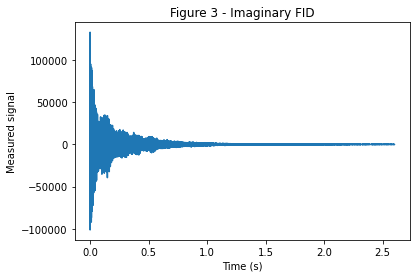

In [54]:
plt.plot(time,data.imag[0])
plt.title("Figure 3 - Imaginary FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

I don't really see any difference between the two, but rest assured, they are different. To turn the FID into a useful spectrum that we can analyze by eye, we have to Fourier transform it. Luckily, the numpy package has a Fourier transform function called fft() (for Fast Fourier Transform).

### Fourier Transform and NMR specturm

In [55]:
fftdata = np.fft.fft(data)

Let's take a look at our NMR spectrum!

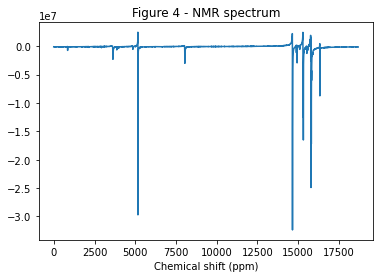

In [56]:
plt.plot(fftdata.real[0])
plt.title("Figure 4 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

Well, that doesn't seem quite right. For a proton NMR we typically expect chemical shifts between 0 and 10, not 17,500. And the peaks are mostly pointing down and have weird edge effects. What went wrong? Nothing, actually, we're just not done yet. First, when we Fourier transform the FID, our x-axis goes from time (s) to frequency (s$^{-1}$), and we have to do an extra step to turn it into chemical shift (ppm). Also, we need to remember that our data is stored as points without time, so we need to also use the fft() function on our time array to create the correct x-axis.

In [57]:
NMR_freq = 400
freq = np.fft.fftfreq(time.shape[0],time_per_point)
chem_shift = -(freq - 1986)/NMR_freq

The TMS peak in this spectrum is at a frequency value of 1986, and so because TMS is our reference for 0 we subtracted that from the frequency to get the TMS peak at zero. So, what does the spectrum look like now?

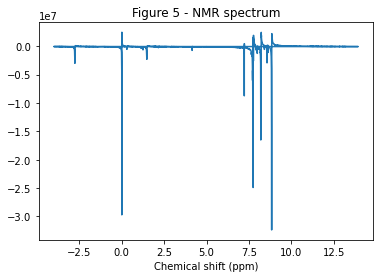

In [58]:
plt.plot(chem_shift,fftdata.real[0])
plt.title("Figure 5 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

It's starting to look better, but we still have two issues. The first, is that standard NMR spectra convention is to have the positive chemical shifts to the left, rather than the right, so we'll need to fix our axis. 
The seconds issue, is that the peaks still look odd. We  This is where the real vs. imaginary FIDs become important. Right now we are only graphing the Fourier transformed real FID, and the result is that our peaks are out of phase with the detector. So we need to combine the real and imaginary data to get everything in phase. If you've messed with the phase setting on the NMR, this is what you are changing. Here, we need to change the phase by hand. Mathematically, this works out to be the real data times $\cos{\theta}$ + imaginary data times times $\sin{\theta}$, where we need to find theta. For this instrument a good value for $\theta$ is 10, this can essenitally be done through trial and error.

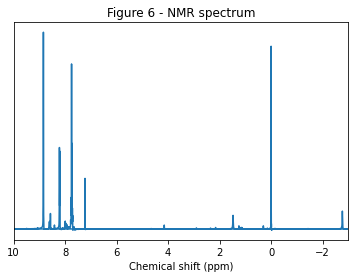

In [59]:
theta = np.degrees(10)
plt.plot(chem_shift,fftdata.real[0]*np.cos(np.radians(theta)) + fftdata.imag[0]*np.sin(np.radians(theta)))
ax = plt.gca()
ax.set_xlim(-3,10)
ax.set_xlim(ax.get_xlim()[::-1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
plt.title("Figure 6 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

And there we have it, the NMR spectrum. If you want, play around with different $\theta$ values to see how that affects the graph. Now, your job is to use the D2O\_fid and D2O\_procpar files to create an NMR spectrum, and compare it to the spectrum above. The spectrum you are graphing is for the same material as above, but *after* some D$_{2}$O has been added to the NMR tube.
## Plotting the NMR after D2O addition

What are the differences between the two spectra? What can you say about the material, knowing that the change was due to the addition of D$_{2}$O?

**Answer here**